This code reads in the Deep Learning network created by running on nutau and nue samples from Dasha.
It is supposed to then create heat maps but I haven't been able to finish that.

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.)

In [1]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Load model
model = load_model('/data/dfc13/DoublePulse/Models/DP_model_10f-3.h5')
model.summary()

W0827 17:33:52.609575 139696025782016 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 17:33:52.636511 139696025782016 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 17:33:52.655780 139696025782016 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0827 17:33:52.720304 139696025782016 deprecation_wrapper.py:119] From /home/dup193/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 58, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 29, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 27, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 5, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 3, 128)        147584    
__________

/home/dup193/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
info_d = []
info_s = []
data_d = []
data_s = []

for i in range(0,1):
    name_dd = "/home/dup193/work/double_pulse/data/first_attemp_data/Tau05to15PeV_00{0}_data.npy".format(i)
    name_di = "/home/dup193/work/double_pulse/data/first_attemp_data/Tau05to15PeV_00{0}_info.pkl".format(i)
    name_sd = "/home/dup193/work/double_pulse/data/first_attemp_data/Electron05to15PeV_00{0}_data.npy".format(i)
    name_si = "/home/dup193/work/double_pulse/data/first_attemp_data/Electron05to15PeV_00{0}_info.pkl".format(i)
    info_d_temp = pickle.load(open(name_di, "rb"))
    info_s_temp = pickle.load(open(name_si, "rb"))
    data_d_temp = np.load(name_dd ,allow_pickle=True,encoding='bytes')
    data_s_temp = np.load(name_sd ,allow_pickle=True,encoding='bytes')
    info_d = info_d + info_d_temp
    info_s = info_s + info_s_temp
    data_d.append(data_d_temp)    
    data_s.append(data_s_temp)
data_d = np.vstack(data_d)
data_s = np.vstack(data_s)
info_d = np.array(info_d)
info_s = np.array(info_s)

In [4]:
data_d = data_d.reshape((len(data_d),300,60,1))
data_d = data_d.astype('float32')/10**-8
data_s = data_s.reshape((len(data_s),300,60,1))
data_s = data_s.astype('float32')/10**-8

In [20]:
tensors = []
decision = []
for i in range(2:3):
    tensor = data_d[i:i+1]
    print(tensor.shape)
    tensors.append(tensor)
    im = tensor.reshape(300,60)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(im.transpose(), interpolation='nearest', aspect='auto', cmap= 'viridis')
    preds = model.predict(tensor)
    print(preds[0])
    decision.append(preds[0]) 
    #fig.close()

SyntaxError: invalid syntax (<ipython-input-20-7e49dbb36012>, line 3)

In [15]:
def MakeHeatmap(tensor, model, layer):
    
    double_pulse_output = model.output[:, 1]
    last_conv_layer = model.get_layer(layer)
    grads = K.gradients(double_pulse_output, last_conv_layer.output)[0]
    #print(grads)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print(pooled_grads)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([tensor])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #heatmap = np.maximum(heatmap, 0)
    
    heatmap /= np.max(heatmap)
    #print(heatmap)
    #plt.matshow(heatmap)
    #plt.show()
    return heatmap    

In [18]:
def Overlay(tensor, heatmap):
    img = tensor.reshape(300,60)
    scale = np.max(img) - np.min(img)
    shift =  np.min(img)
    img  = (img-shift)/scale
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for (x,y,i) ,val in np.ndenumerate(img):
        if i == 0:
            img[x,y] = [val,0,0]
 
    heatmap_scd = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    scale = np.max(heatmap_scd) - np.min(heatmap_scd)
    shift =  np.min(heatmap_scd)
    heatmap_scd  = (heatmap_scd-shift)/scale*2
    heatmap_scd = cv2.cvtColor(heatmap_scd,cv2.COLOR_GRAY2RGB)
    for (x,y,i) ,val in np.ndenumerate(heatmap_scd):
        if i == 0:
            heatmap_scd[x,y] = [0,val,0]
    superimposed_img = heatmap_scd+img

    return(superimposed_img)

/home/dup193/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
W0827 17:40:34.640154 139696025782016 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/dup193/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
W0827 17:40:35.400738 139696025782016 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/dup193/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
W082

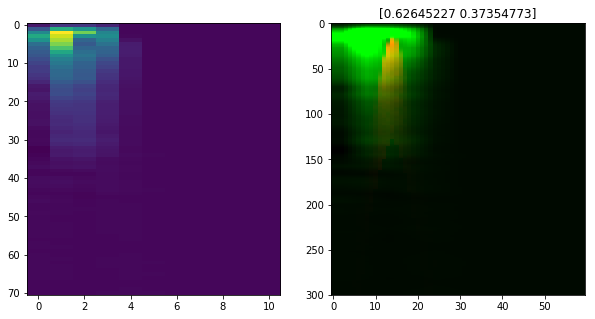

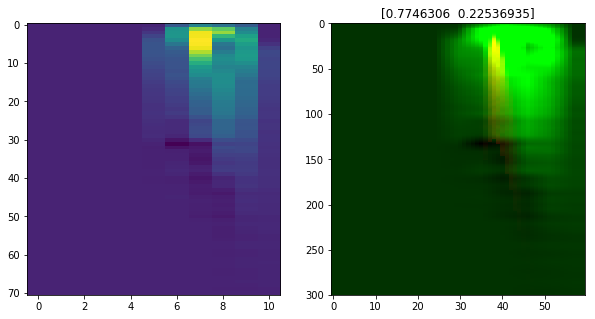

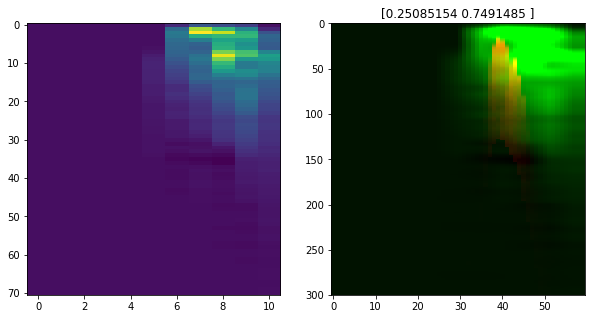

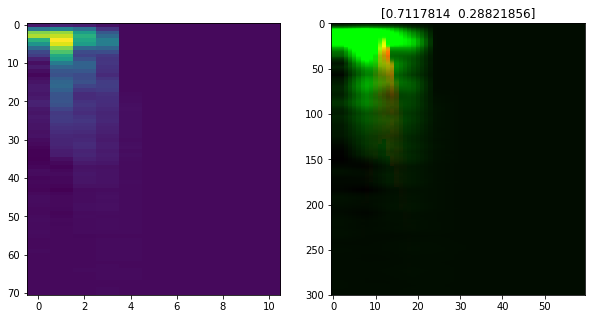

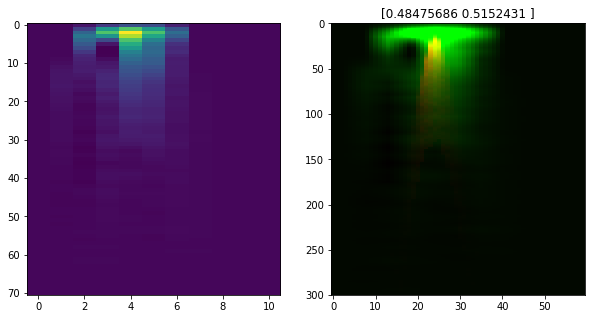

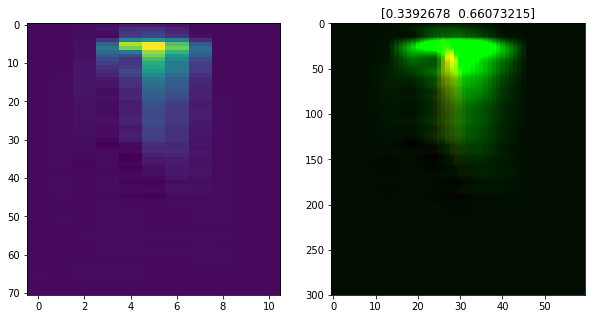

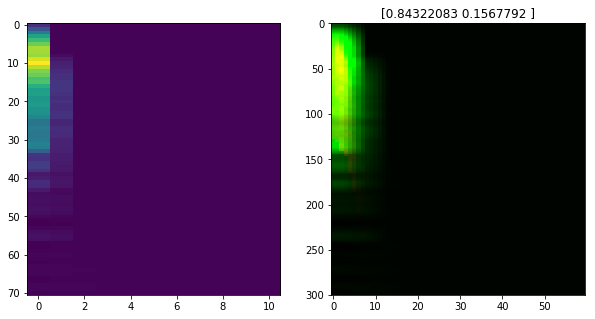

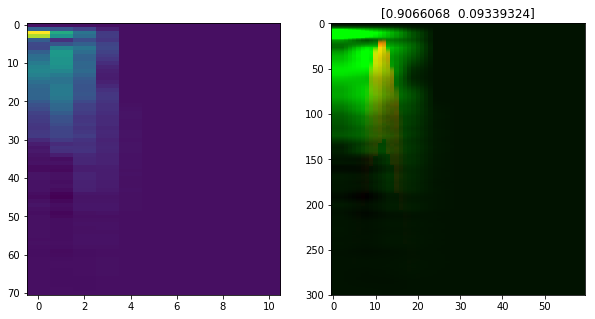

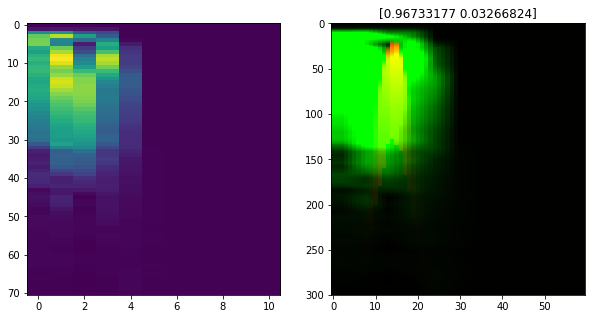

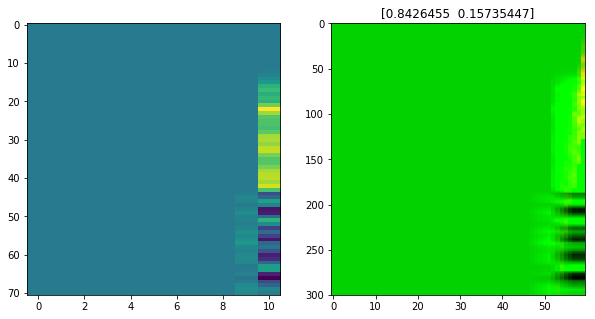

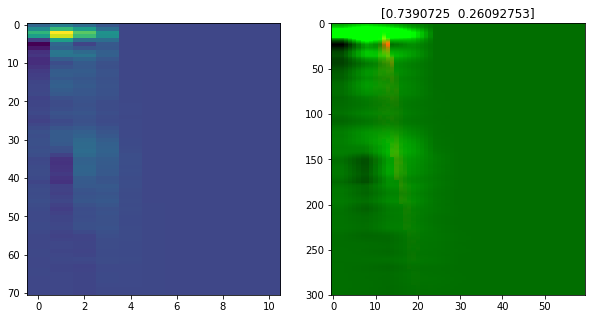

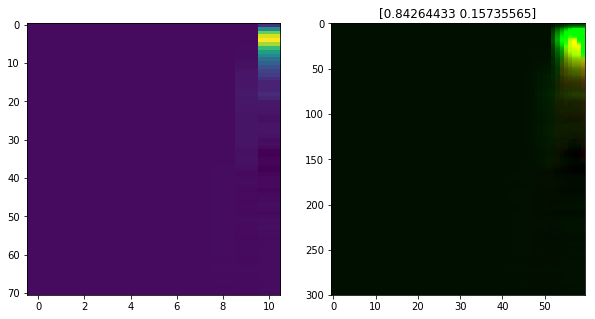

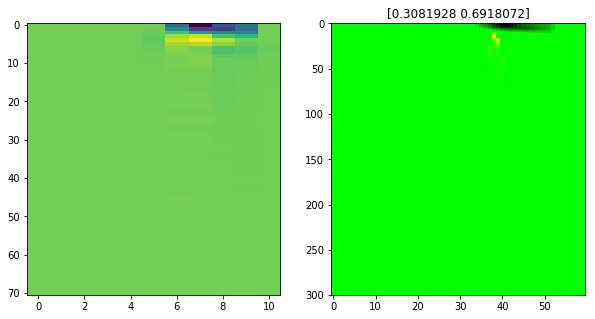

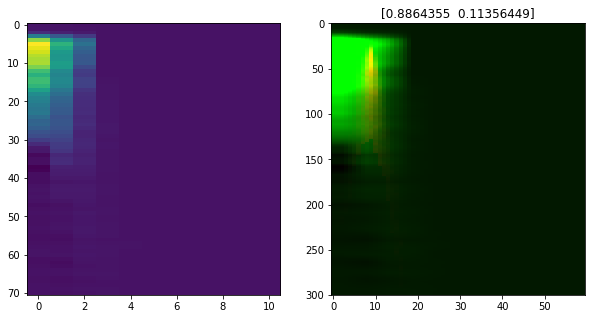

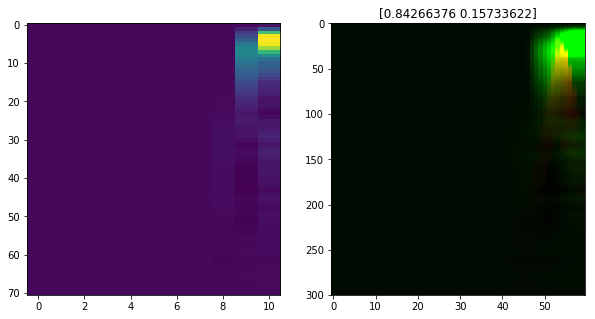

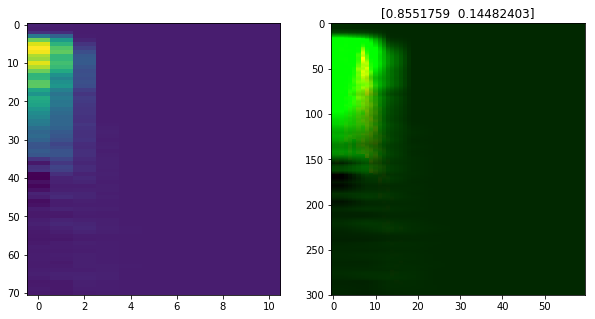

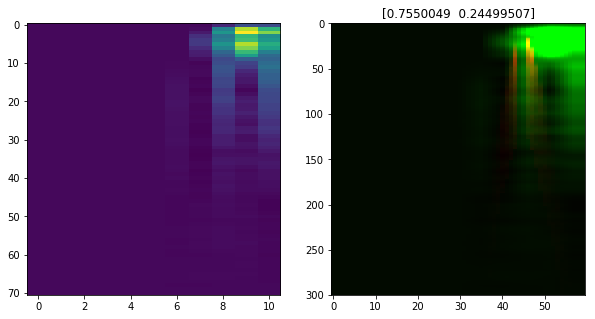

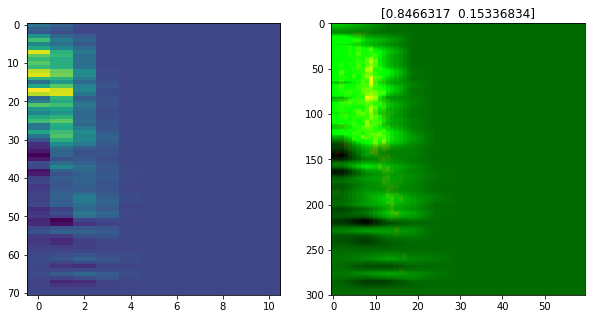

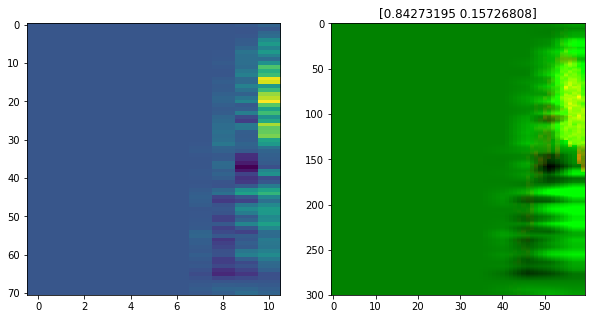

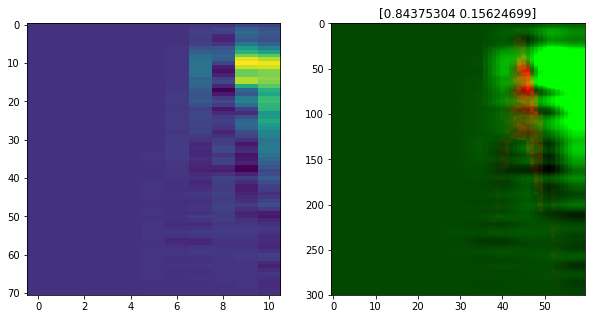

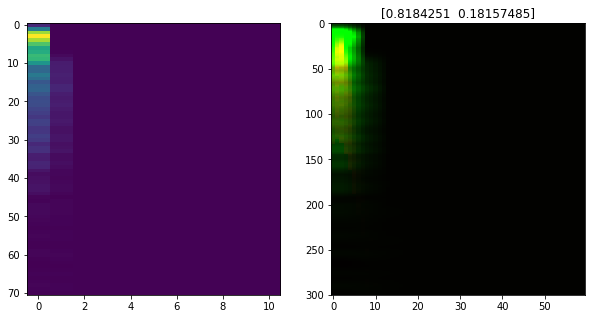

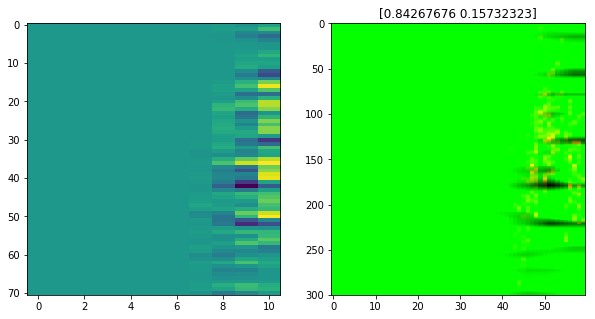

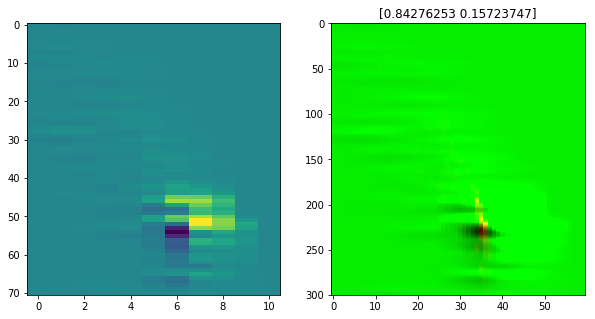

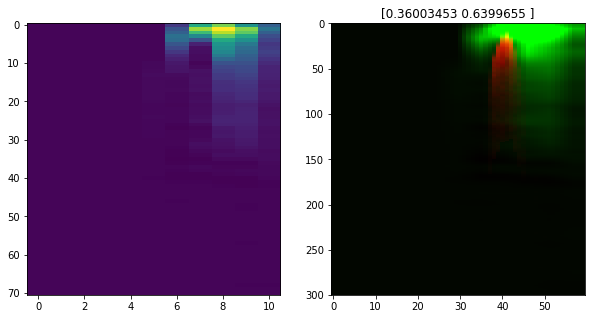

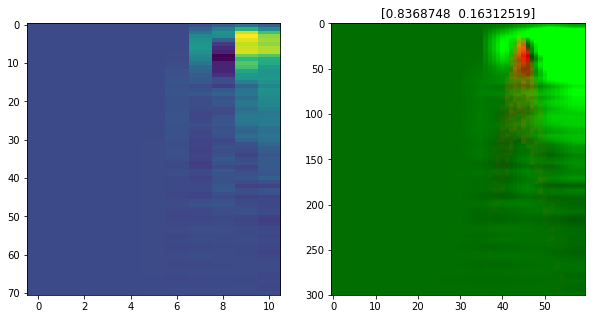

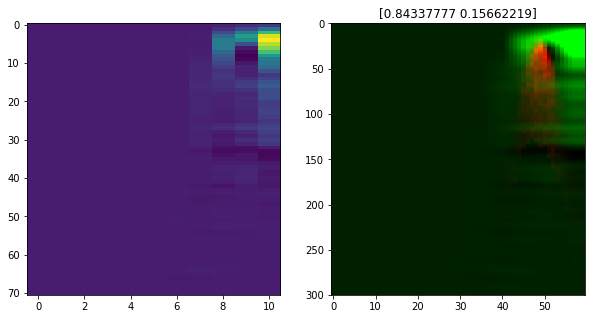

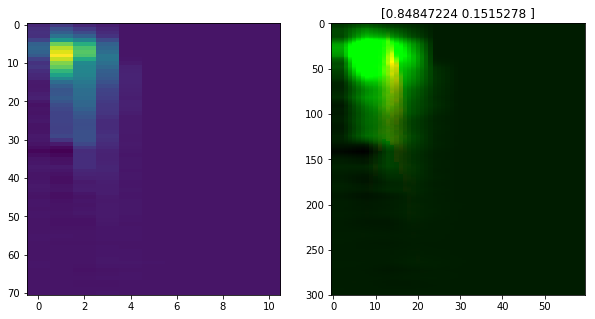

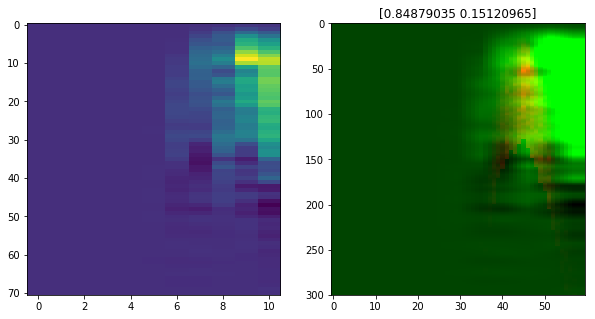

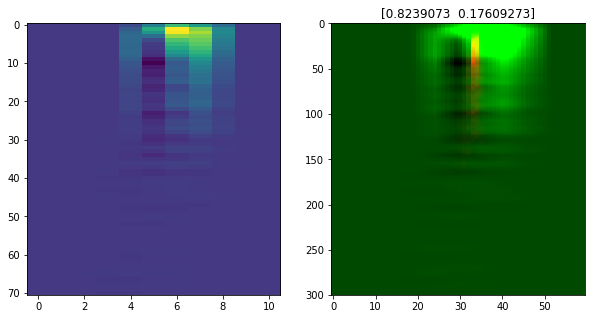

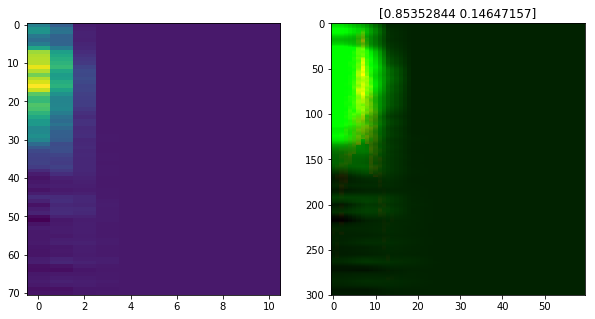

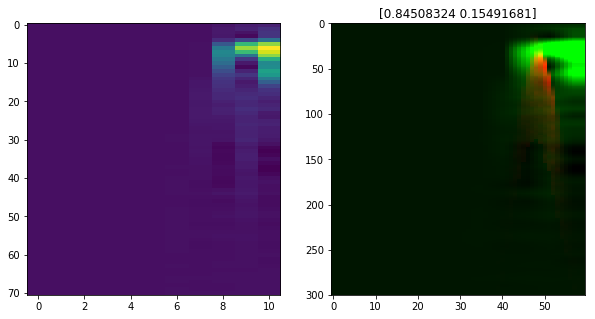

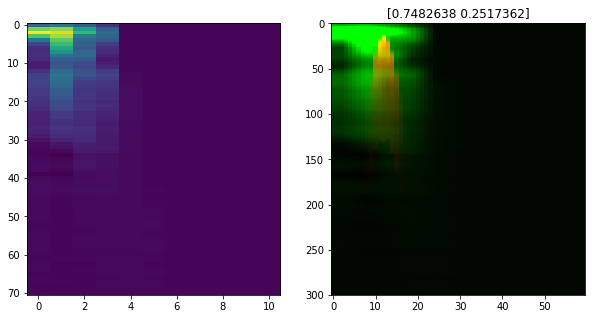

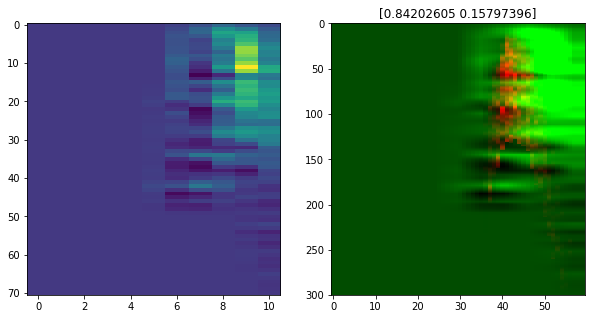

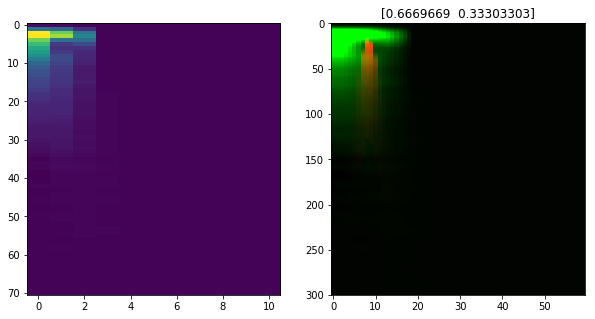

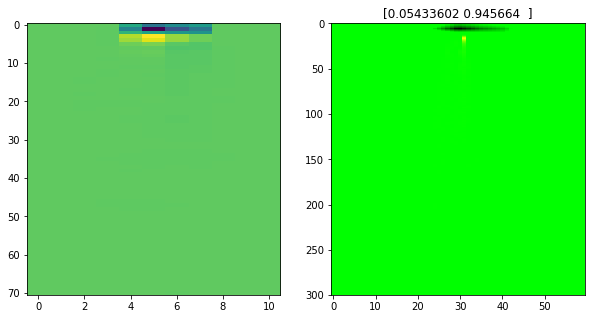

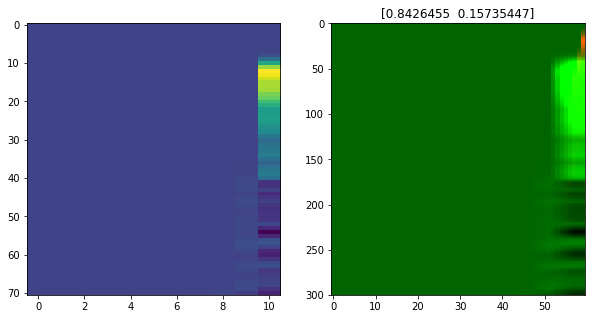

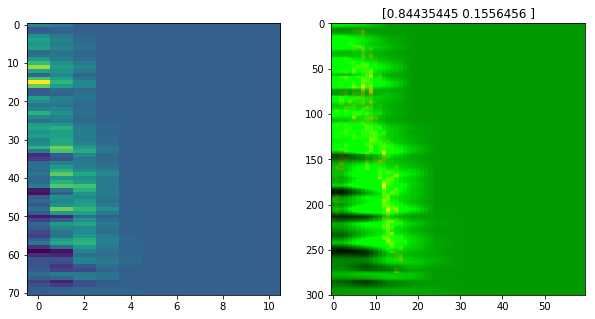

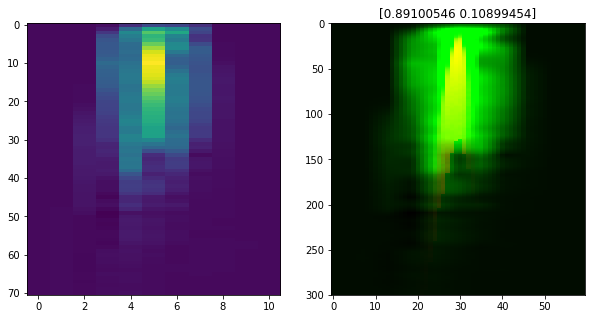

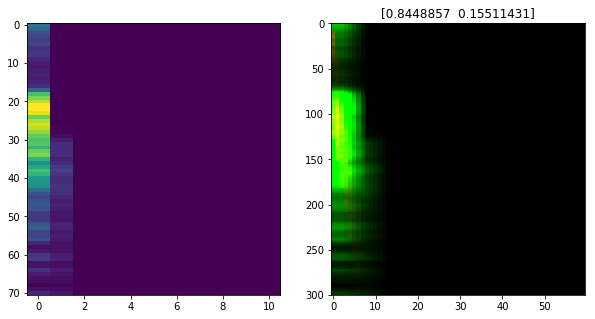

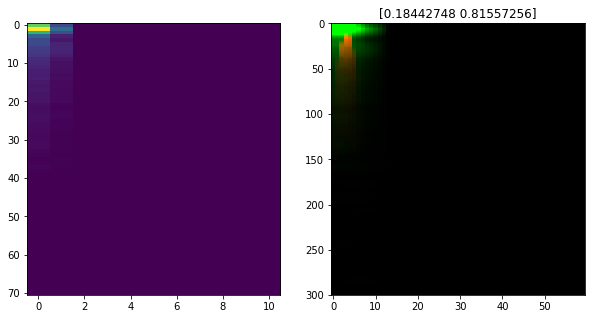

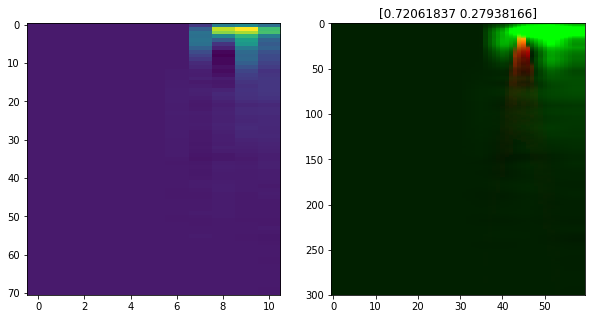

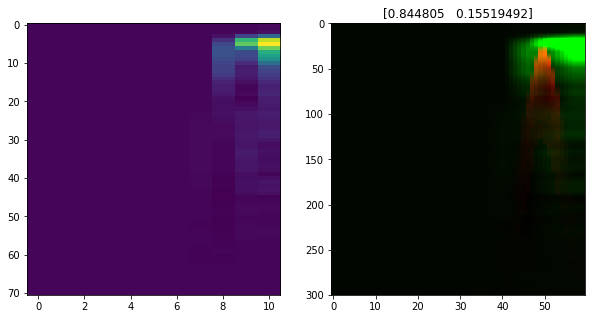

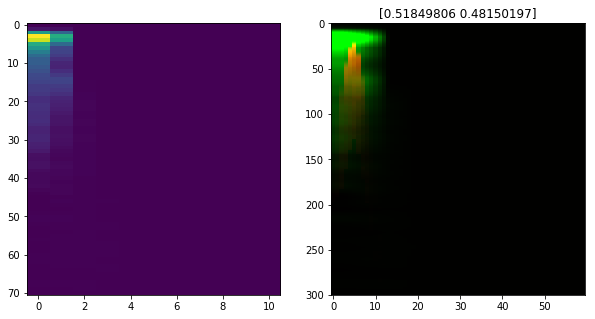

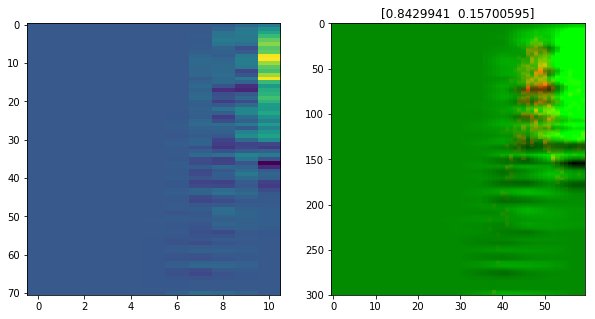

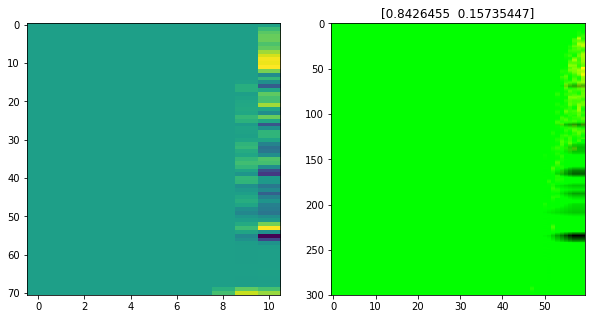

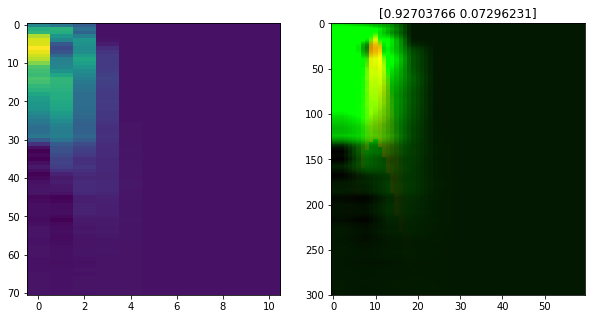

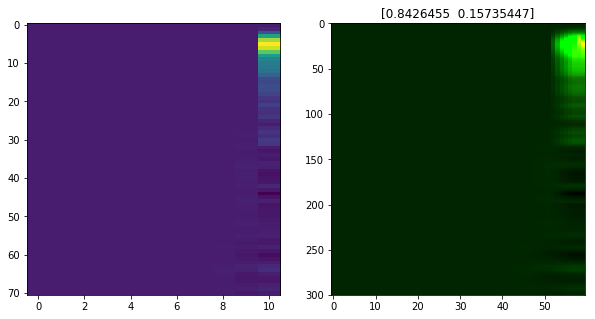

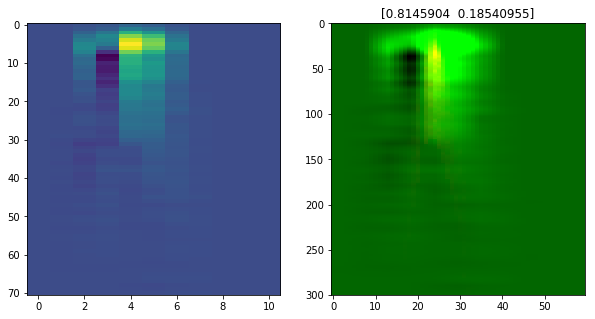

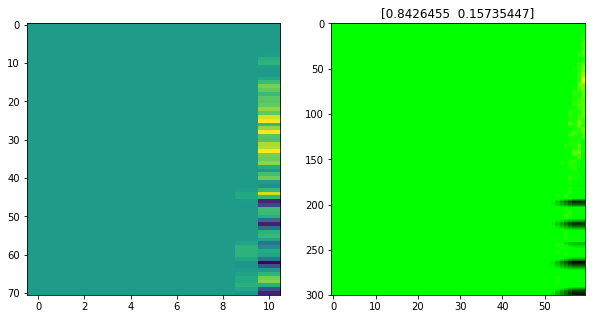

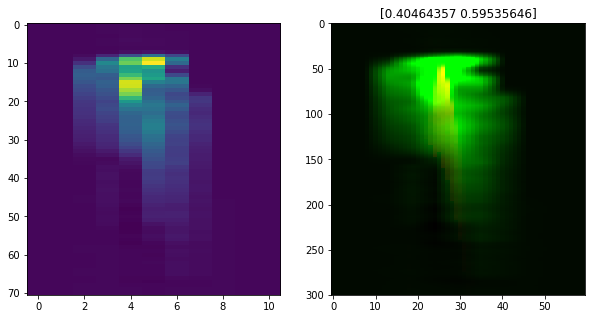

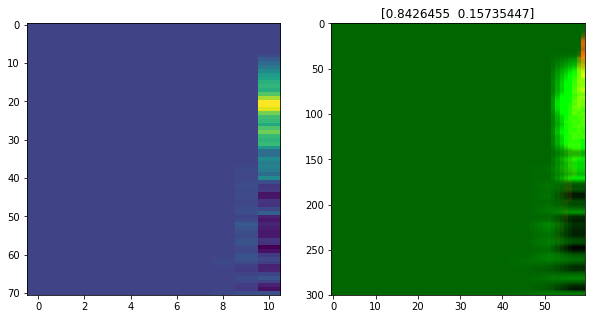

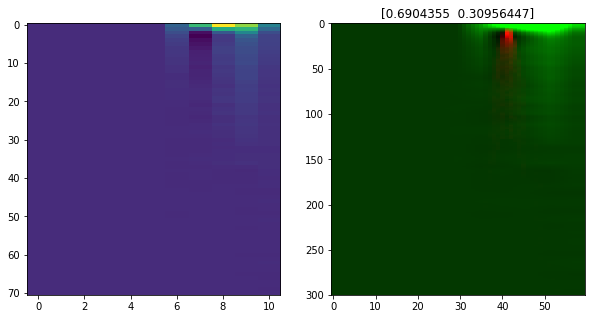

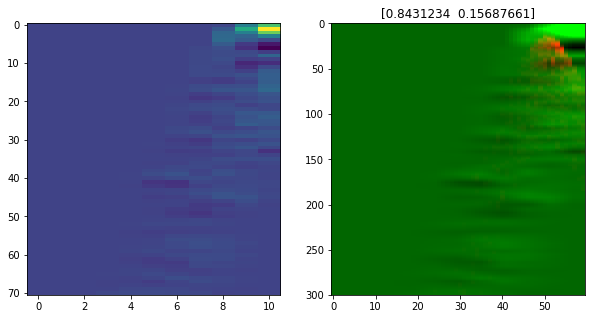

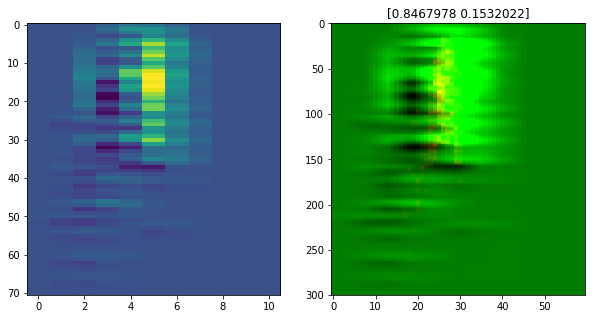

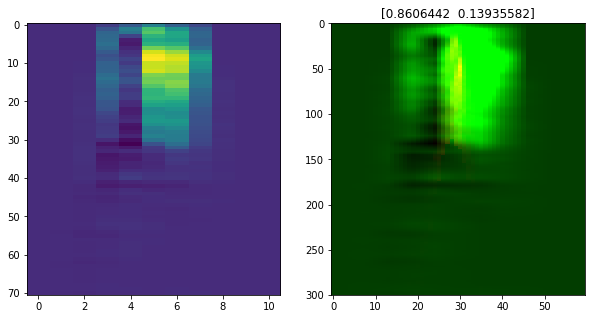

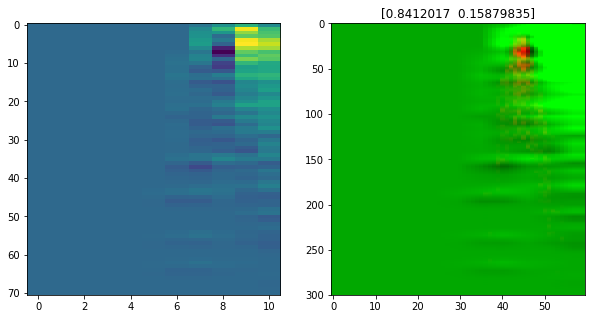

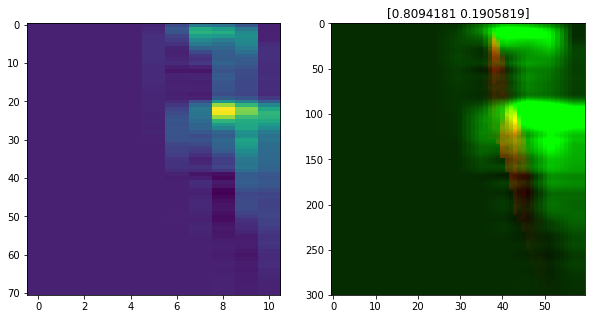

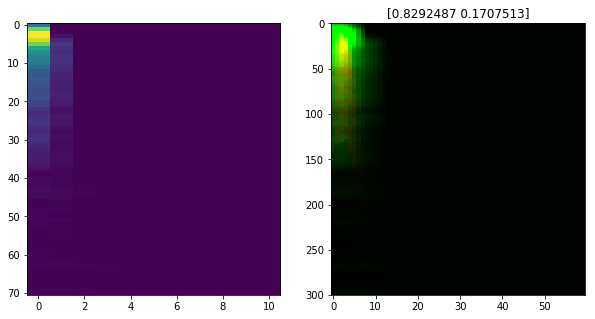

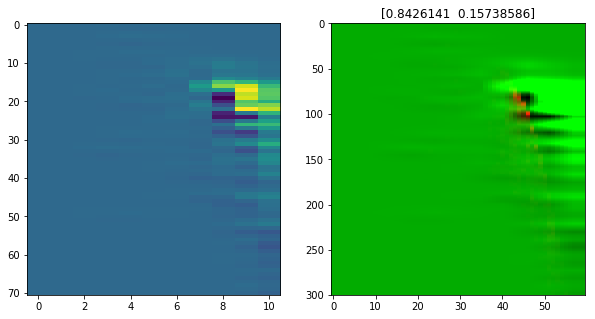

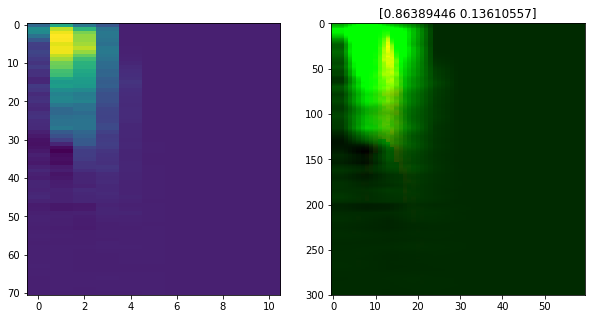

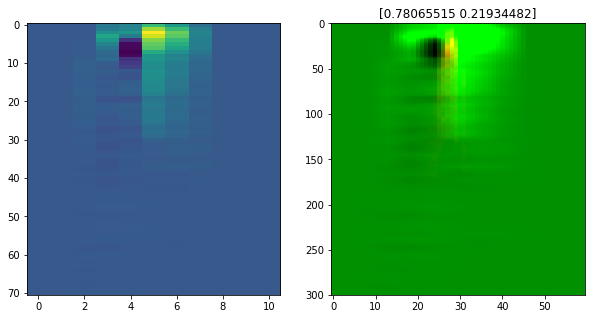

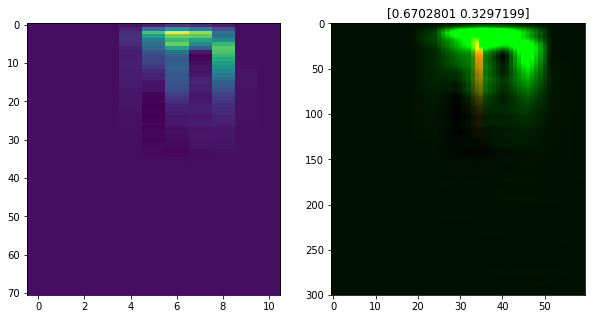

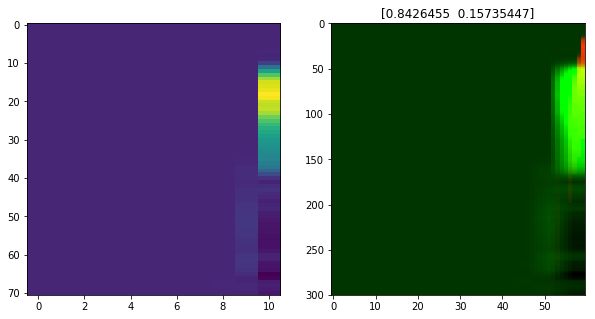

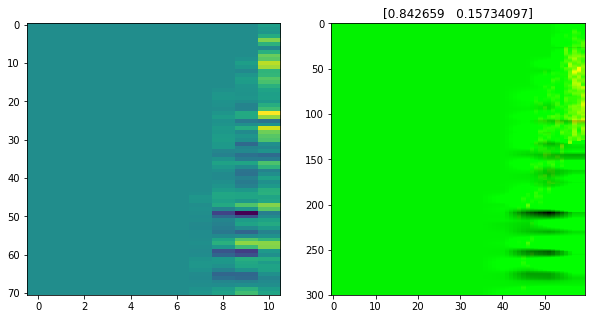

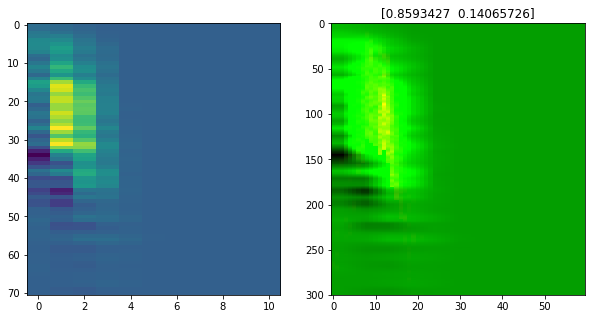

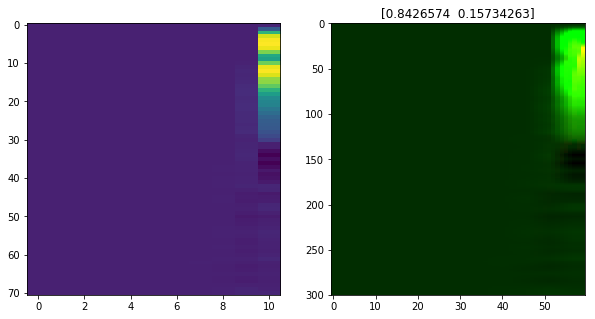

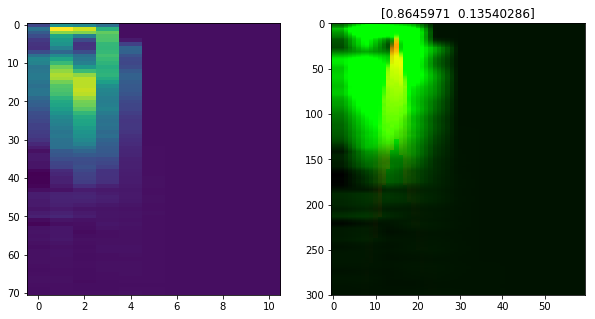

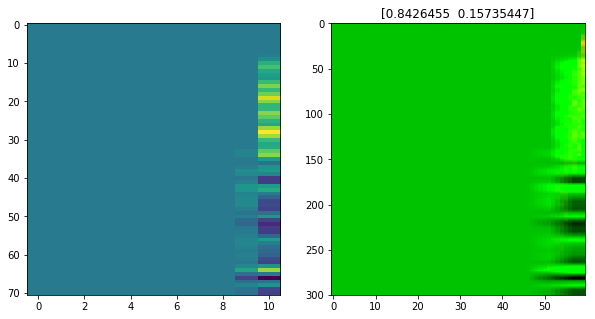

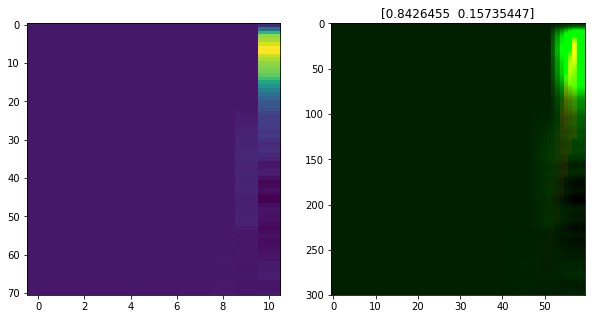

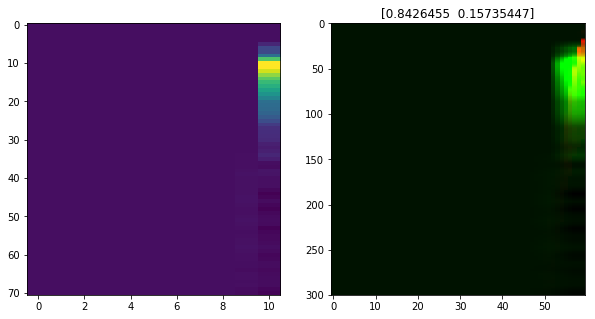

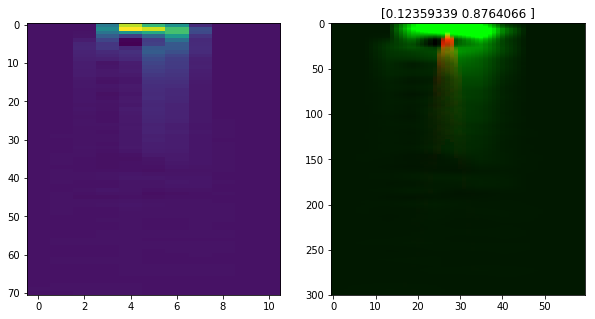

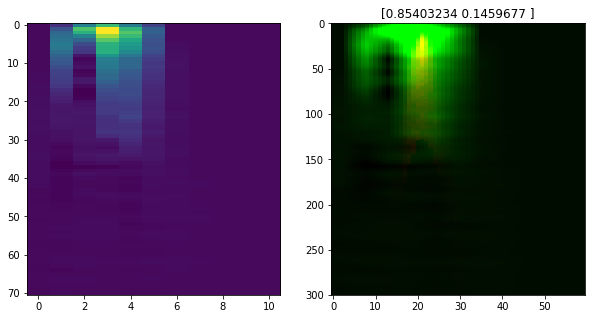

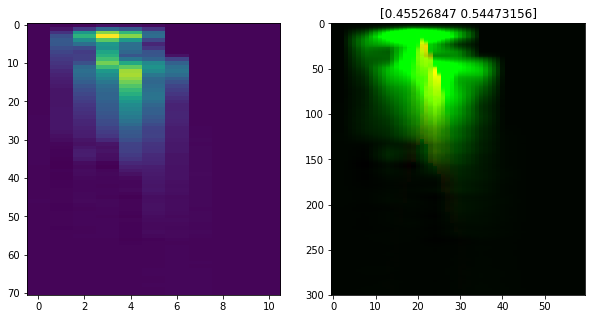

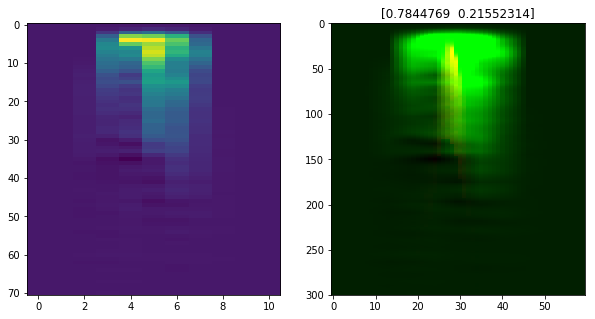

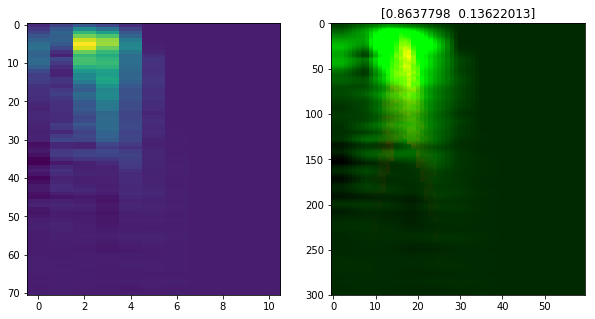

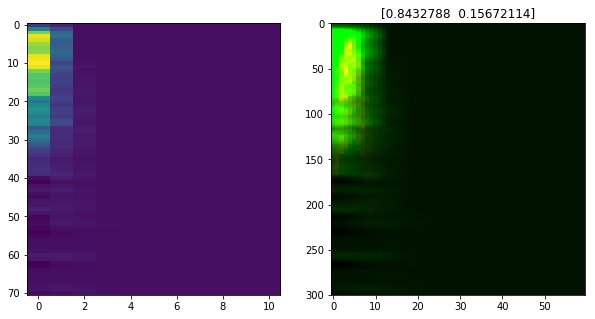

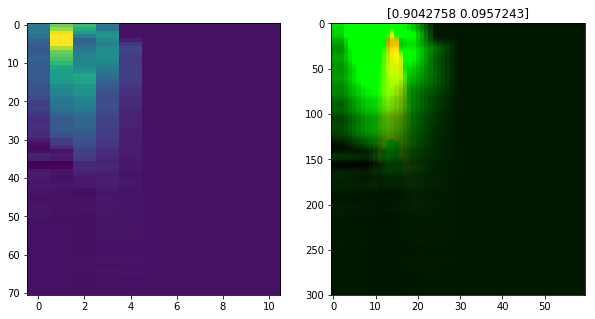

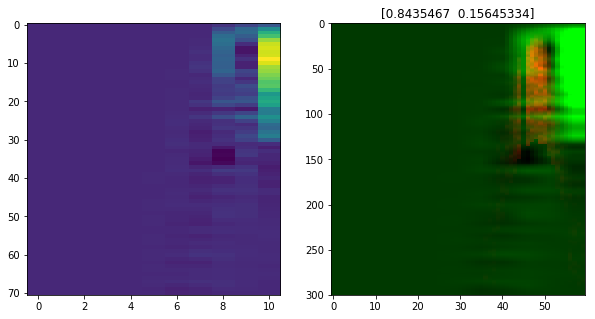

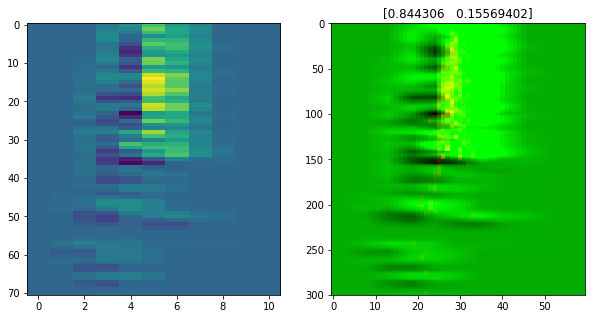

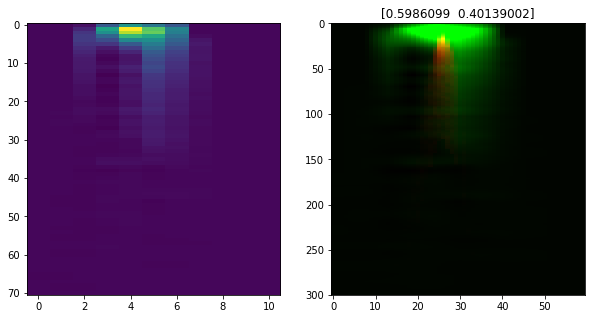

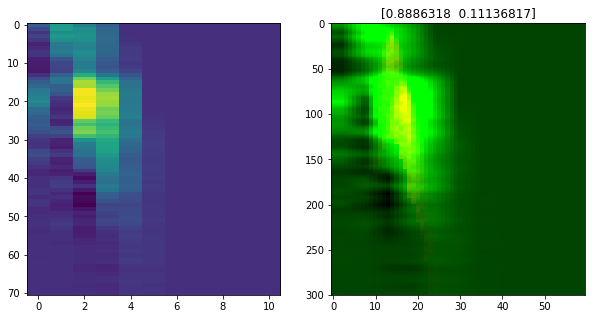

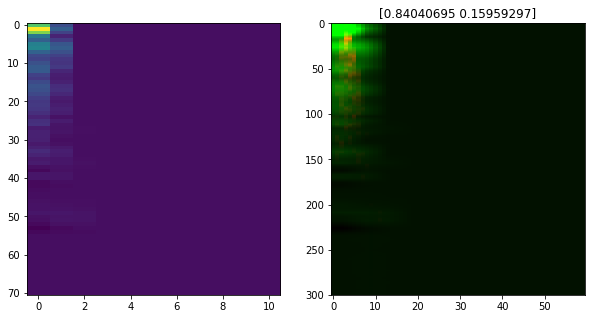

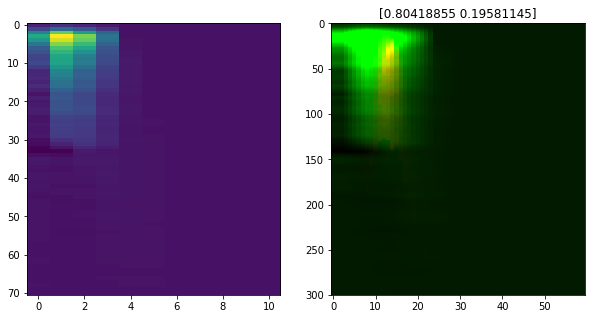

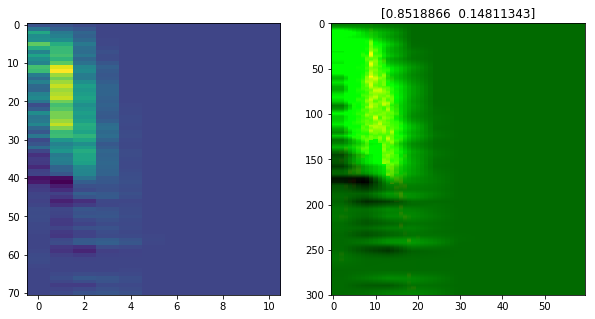

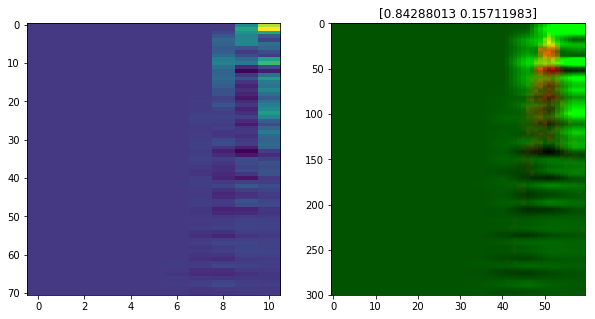

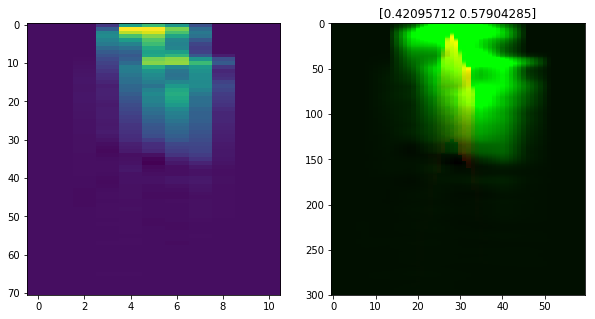

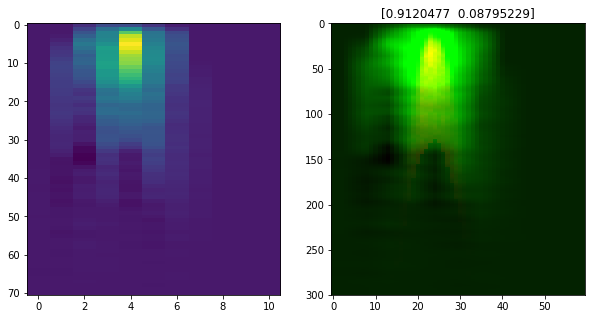

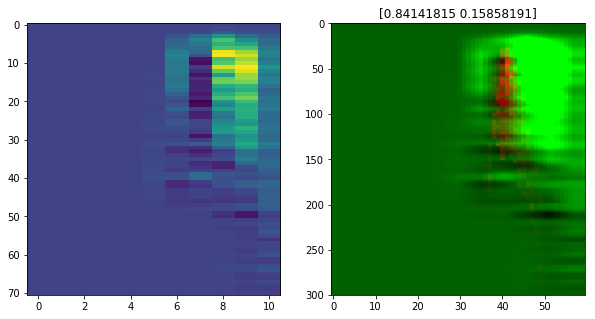

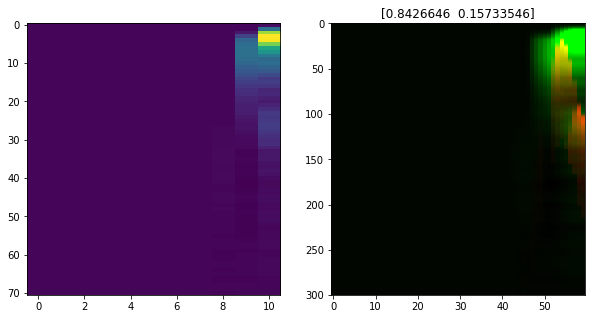

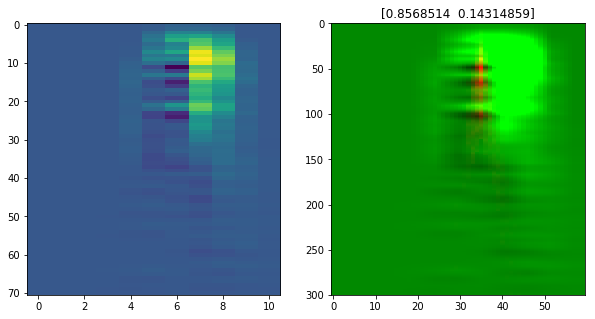

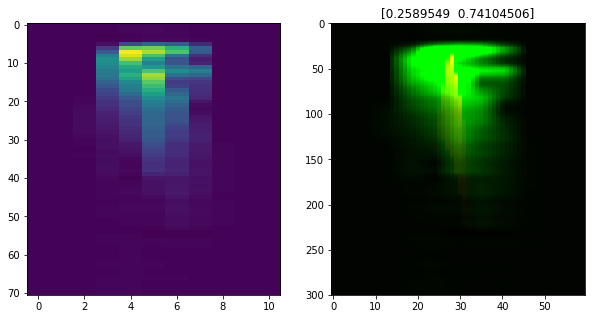

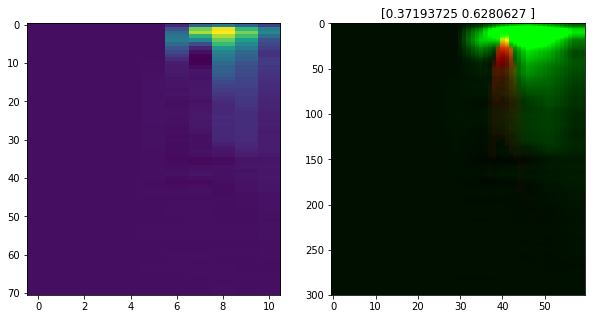

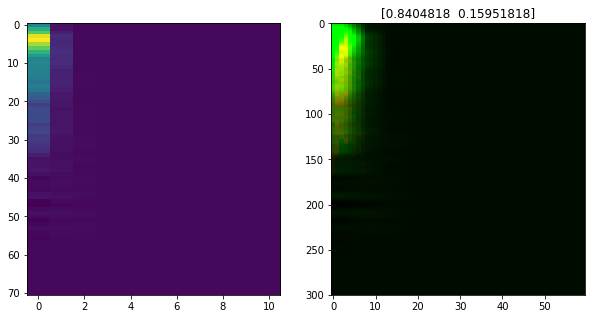

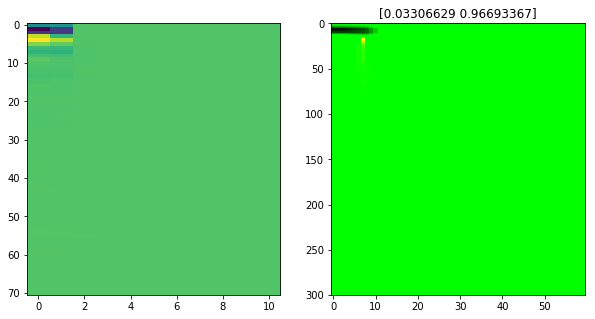

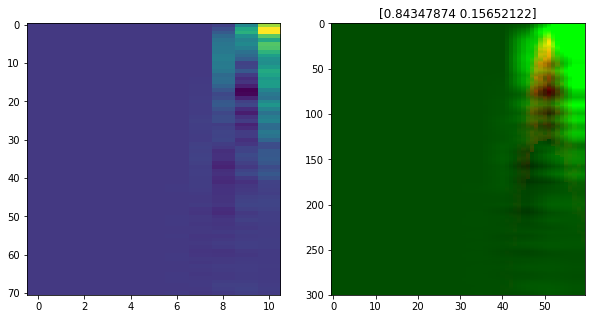

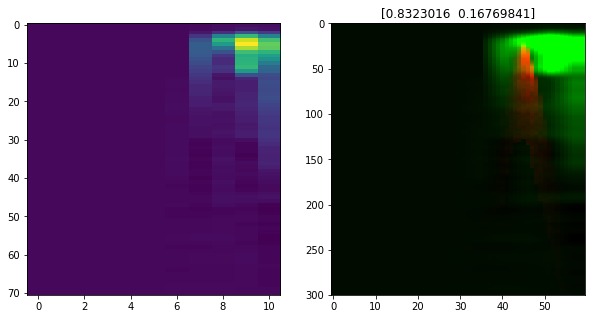

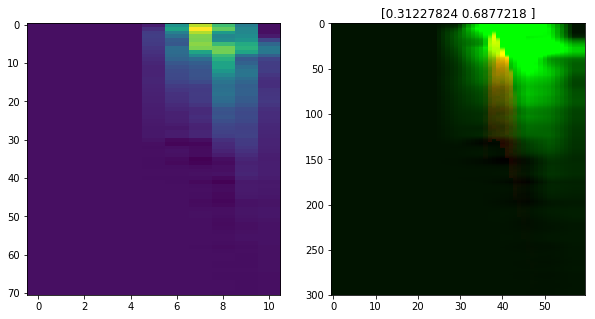

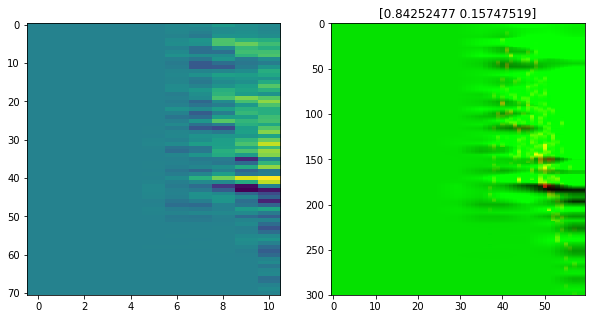

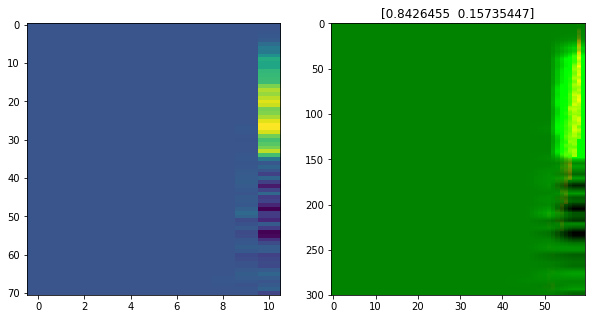

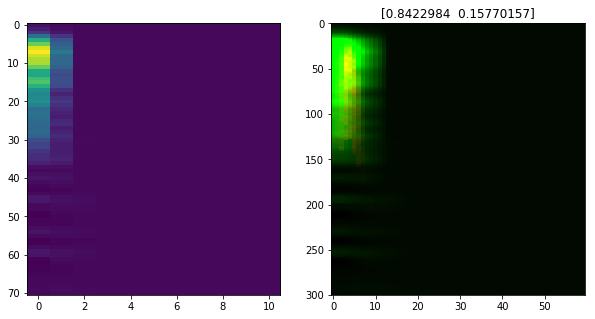

In [19]:
for i, tensor in enumerate(tensors):
    htmap = MakeHeatmap(tensor, model,'conv2d_3')
    spos = Overlay(tensor,htmap)

    f, ax_arr = plt.subplots(1,2,figsize=(10, 5))
    plt.title(decision[i])
    ax_arr[0].imshow(htmap,aspect='auto')
    ax_arr[1].imshow(spos,aspect='auto')

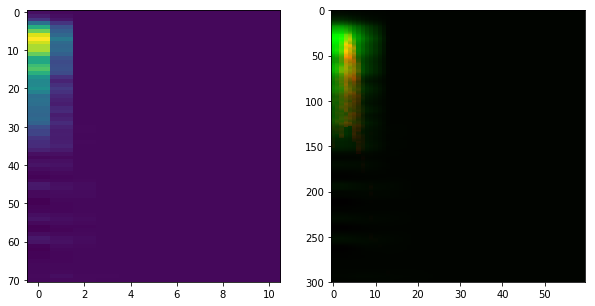

In [9]:
htmap = MakeHeatmap(tensor, model,'conv2d_3')
spos = Overlay(tensor,htmap)

f, ax_arr = plt.subplots(1,2,figsize=(10, 5))
ax_arr[0].imshow(htmap,aspect='auto')
ax_arr[1].imshow(spos,aspect='auto')